# Generalities for DAEs and VAEs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Neural Network classes

* Deterministic auto-encoder (DAE)
* Variational auto-encoder (VAE)


In [ ]:
# Deterministic Auto-Encoder (DAE)
class DAE(nn.Module):

    # declare layers
    def __init__(self):
        super(DAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # encoder: one ReLU hidden layer of 400 nodes, one Linear output layer of 20 nodes
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h)

    # decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # forward: encoder followed by decoder
    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        return self.decode(z)

# Variational Auto-Encoder (VAE)     
class VAE(nn.Module):

    # declare layers
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)


    # Encoder: one ReLU hidden layer of 400 nodes, two Linear output layers of 20 nodes (means and log_variances)
    # Input: image (array of size 784)
    # Output: means (array of size 20), log_variances (array of size 20)
    def encode(self, x):

        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    # Reparameterization:
    #
    # Let eps be samples from a Normal(0,1)
    # Input: means (array of size 20), log_variances (array of size 20)
    # Output: embedding (array of size 20 corresponding to means + eps * exponential(log_variances/2))
    def reparameterize(self, means, log_variances):

        std = torch.exp(0.5 * log_variances)
        embedding = means + torch.rand_like(std) * std
        return embedding

    # Decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    # Input: embedding (array of size 20)
    # Output: probability of reconstructed image (array of size 784)
    def decode(self, z):

        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # Function forward: encoder, reparameterize, decoder
    # Input: image
    # Output: probability of reconstructed image, means, log_variances
    def forward(self, x):

        means, log_variances = self.encode(x.view(-1, 784))
        z = self.reparameterize(means, log_variances)
        return self.decode(z), means, log_variances

# Loss Functions

In [ ]:
# DAE Loss Function
# Reconstruction loss: binary cross entropy
#
# Inputs:
#    reconstructed_x: reconstructed image
#    x: image
#
# Output:
#    BCE: binary cross entropy  
#
def dae_loss_function(reconstructed_x, x):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    return BCE

# VAE Loss Function
# Reconstruction loss: binary cross entropy
# KL divergence loss: -0.5 * sum(1 + log_variances - means^2 - exp(log_variances))
#       see Appendix B from VAE paper:
#       Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#       https://arxiv.org/abs/1312.6114
#
# Inputs: 
#    reconstructed_x: reconstructed image
#    x: image
#    means: array of size 20
#    log_variances: array of size 20
#
# Outputs:
#    total_loss: binary cross entropy + KL divergence (scalar)
#    BCE: binary cross entropy (scalar)
#
def vae_loss_function(reconstructed_x, x, means, log_variances):

    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_variances - means.pow(2) - log_variances.exp())
    total_loss = BCE + KLD
    return total_loss, BCE


# Training

In [ ]:
# DAE Training
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#    optimizer: DAE optimizer
#
# Outputs:
#    average_train_BCE: binary cross entropy (scalar)
#
def dae_train(epoch, model, optimizer):
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = dae_loss_function(recon_batch, data)
        loss.backward()
        train_BCE += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_BCE))
    return average_train_BCE

# VAE Training
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#    optimizer: VAE optimizer
#
# Outputs:
#    average_train_loss: binary cross entropy + KL divergence (scalar)
#    average_train_BCE: binary cross entropy (scalar)
#
def vae_train(epoch, model, optimizer):

    # dummy assignment until this function is filled in
    model.train()
    train_loss = 0
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, means, log_variances = model(data)
        total_loss, BCE = vae_loss_function(recon_batch, data, means, log_variances)
        total_loss.backward()
        train_loss += total_loss.item()
        train_BCE += BCE.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                total_loss.item() / len(data)))
    average_train_loss = train_loss / len(train_loader.dataset)
    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average train loss: {:.4f}'.format(
          epoch, average_train_loss))
    print('====> Epoch: {} Average train BCE: {:.4f}'.format(
          epoch, average_train_BCE))
    return average_train_loss, average_train_BCE



# Testing

In [ ]:
# DAE Test
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#
# Outputs:
#    average_test_BCE: binary cross entropy (scalar)
#
def dae_test(epoch, model):
    model.eval()
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_BCE += dae_loss_function(recon_batch, data).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_BCE))
    return average_test_BCE

# VAE Test
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#
# Outputs:
#    average_test_loss: binary cross entropy + KL divergence (scalar)
#    average_test_BCE: binary cross entropy (scalar)
#
def vae_test(epoch, model):

    model.eval()
    test_BCE = 0
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, means, log_variances = model(data)
            loss, BCE = vae_loss_function(recon_batch, data, means, log_variances)
            test_BCE += BCE.item()
            test_loss += loss.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE / len(test_loader.dataset)
    average_test_loss = test_loss / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_loss))
    print('====> Test set BCE: {:.4f}'.format(average_test_BCE))
    return average_test_loss, average_test_BCE


# Main

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.925598
Train Epoch: 1 [12800/60000 (21%)]	Loss: 140.612518
Train Epoch: 1 [25600/60000 (43%)]	Loss: 108.099838
Train Epoch: 1 [38400/60000 (64%)]	Loss: 104.251953
Train Epoch: 1 [51200/60000 (85%)]	Loss: 91.867294
====> Epoch: 1 Average loss: 131.0970
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


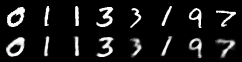

====> Test set loss: 87.6041
Sample of generated images


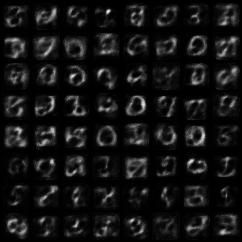



Train Epoch: 2 [0/60000 (0%)]	Loss: 87.986237
Train Epoch: 2 [12800/60000 (21%)]	Loss: 84.376839
Train Epoch: 2 [25600/60000 (43%)]	Loss: 85.275551
Train Epoch: 2 [38400/60000 (64%)]	Loss: 79.297089
Train Epoch: 2 [51200/60000 (85%)]	Loss: 75.177635
====> Epoch: 2 Average loss: 82.5477
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


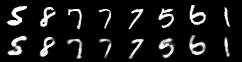

====> Test set loss: 77.8207
Sample of generated images


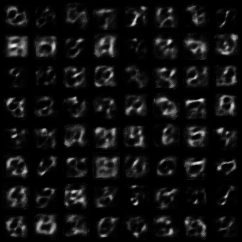



Train Epoch: 3 [0/60000 (0%)]	Loss: 80.201622
Train Epoch: 3 [12800/60000 (21%)]	Loss: 78.696167
Train Epoch: 3 [25600/60000 (43%)]	Loss: 70.517067
Train Epoch: 3 [38400/60000 (64%)]	Loss: 75.628052
Train Epoch: 3 [51200/60000 (85%)]	Loss: 78.929649
====> Epoch: 3 Average loss: 76.9215
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


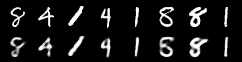

====> Test set loss: 74.7597
Sample of generated images


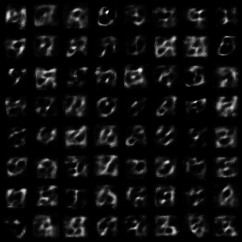



Train Epoch: 4 [0/60000 (0%)]	Loss: 75.665550
Train Epoch: 4 [12800/60000 (21%)]	Loss: 77.995224
Train Epoch: 4 [25600/60000 (43%)]	Loss: 75.075729
Train Epoch: 4 [38400/60000 (64%)]	Loss: 74.163681
Train Epoch: 4 [51200/60000 (85%)]	Loss: 70.421288
====> Epoch: 4 Average loss: 74.2369
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


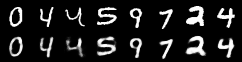

====> Test set loss: 72.6107
Sample of generated images


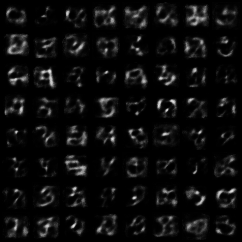



Train Epoch: 5 [0/60000 (0%)]	Loss: 74.191025
Train Epoch: 5 [12800/60000 (21%)]	Loss: 73.106857
Train Epoch: 5 [25600/60000 (43%)]	Loss: 76.007919
Train Epoch: 5 [38400/60000 (64%)]	Loss: 71.665802
Train Epoch: 5 [51200/60000 (85%)]	Loss: 73.141983
====> Epoch: 5 Average loss: 72.4881
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


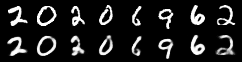

====> Test set loss: 71.2046
Sample of generated images


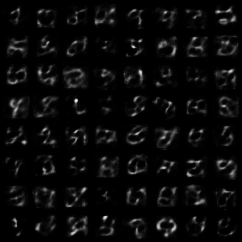



Train Epoch: 6 [0/60000 (0%)]	Loss: 70.854691
Train Epoch: 6 [12800/60000 (21%)]	Loss: 68.591309
Train Epoch: 6 [25600/60000 (43%)]	Loss: 72.382980
Train Epoch: 6 [38400/60000 (64%)]	Loss: 72.368973
Train Epoch: 6 [51200/60000 (85%)]	Loss: 71.617081
====> Epoch: 6 Average loss: 71.2551
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


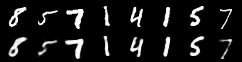

====> Test set loss: 70.2605
Sample of generated images


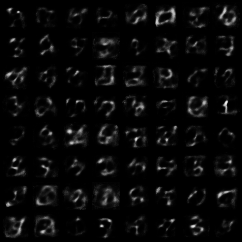



Train Epoch: 7 [0/60000 (0%)]	Loss: 65.273193
Train Epoch: 7 [12800/60000 (21%)]	Loss: 69.552460
Train Epoch: 7 [25600/60000 (43%)]	Loss: 71.517456
Train Epoch: 7 [38400/60000 (64%)]	Loss: 70.193237
Train Epoch: 7 [51200/60000 (85%)]	Loss: 68.170547
====> Epoch: 7 Average loss: 70.2796
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


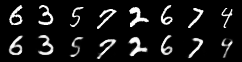

====> Test set loss: 69.6109
Sample of generated images


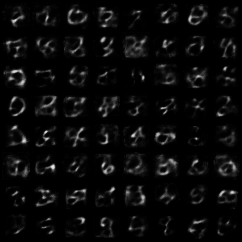



Train Epoch: 8 [0/60000 (0%)]	Loss: 69.163666
Train Epoch: 8 [12800/60000 (21%)]	Loss: 72.562668
Train Epoch: 8 [25600/60000 (43%)]	Loss: 69.682556
Train Epoch: 8 [38400/60000 (64%)]	Loss: 71.093552
Train Epoch: 8 [51200/60000 (85%)]	Loss: 72.672417
====> Epoch: 8 Average loss: 69.5374
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


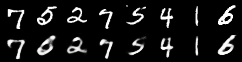

====> Test set loss: 69.0003
Sample of generated images


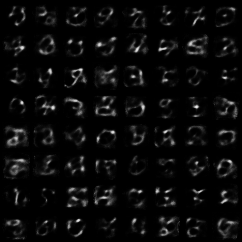



Train Epoch: 9 [0/60000 (0%)]	Loss: 65.536880
Train Epoch: 9 [12800/60000 (21%)]	Loss: 67.724861
Train Epoch: 9 [25600/60000 (43%)]	Loss: 69.260605
Train Epoch: 9 [38400/60000 (64%)]	Loss: 68.444771
Train Epoch: 9 [51200/60000 (85%)]	Loss: 67.127846
====> Epoch: 9 Average loss: 68.9054
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


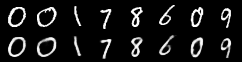

====> Test set loss: 68.6043
Sample of generated images


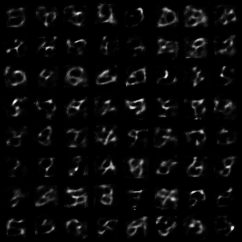



Train Epoch: 10 [0/60000 (0%)]	Loss: 67.957321
Train Epoch: 10 [12800/60000 (21%)]	Loss: 66.938782
Train Epoch: 10 [25600/60000 (43%)]	Loss: 69.304863
Train Epoch: 10 [38400/60000 (64%)]	Loss: 68.851295
Train Epoch: 10 [51200/60000 (85%)]	Loss: 65.052216
====> Epoch: 10 Average loss: 68.3874
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


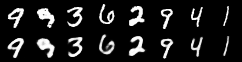

====> Test set loss: 67.9653
Sample of generated images


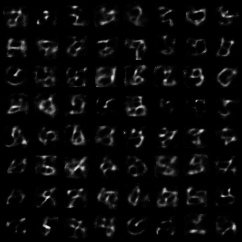



Train Epoch: 1 [0/60000 (0%)]	Loss: 546.639648
Train Epoch: 1 [12800/60000 (21%)]	Loss: 158.710510
Train Epoch: 1 [25600/60000 (43%)]	Loss: 131.859375
Train Epoch: 1 [38400/60000 (64%)]	Loss: 115.988251
Train Epoch: 1 [51200/60000 (85%)]	Loss: 115.679733
====> Epoch: 1 Average train loss: 144.1094
====> Epoch: 1 Average train BCE: 136.7959
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


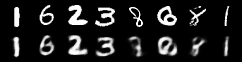

====> Test set loss: 107.8473
====> Test set BCE: 99.0352
Sample of generated images


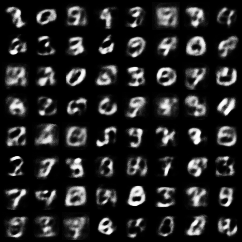



Train Epoch: 2 [0/60000 (0%)]	Loss: 112.990356
Train Epoch: 2 [12800/60000 (21%)]	Loss: 102.316628
Train Epoch: 2 [25600/60000 (43%)]	Loss: 101.186172
Train Epoch: 2 [38400/60000 (64%)]	Loss: 105.812256
Train Epoch: 2 [51200/60000 (85%)]	Loss: 103.229485
====> Epoch: 2 Average train loss: 102.3850
====> Epoch: 2 Average train BCE: 93.0387
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


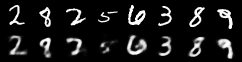

====> Test set loss: 97.8653
====> Test set BCE: 88.0947
Sample of generated images


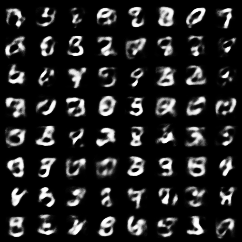



Train Epoch: 3 [0/60000 (0%)]	Loss: 100.675461
Train Epoch: 3 [12800/60000 (21%)]	Loss: 100.807495
Train Epoch: 3 [25600/60000 (43%)]	Loss: 95.028580
Train Epoch: 3 [38400/60000 (64%)]	Loss: 96.870651
Train Epoch: 3 [51200/60000 (85%)]	Loss: 92.111176
====> Epoch: 3 Average train loss: 96.4670
====> Epoch: 3 Average train BCE: 86.7418
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


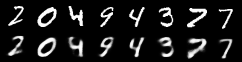

====> Test set loss: 93.7069
====> Test set BCE: 83.8343
Sample of generated images


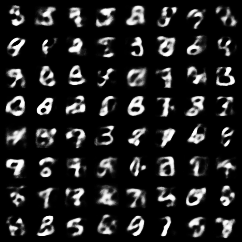



Train Epoch: 4 [0/60000 (0%)]	Loss: 94.000435
Train Epoch: 4 [12800/60000 (21%)]	Loss: 91.783859
Train Epoch: 4 [25600/60000 (43%)]	Loss: 95.606995
Train Epoch: 4 [38400/60000 (64%)]	Loss: 91.032043
Train Epoch: 4 [51200/60000 (85%)]	Loss: 91.408897
====> Epoch: 4 Average train loss: 93.4668
====> Epoch: 4 Average train BCE: 83.5860
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


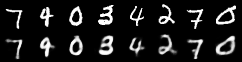

====> Test set loss: 91.5567
====> Test set BCE: 81.6664
Sample of generated images


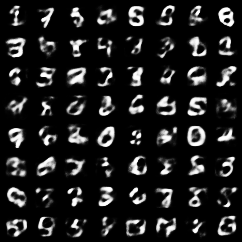



Train Epoch: 5 [0/60000 (0%)]	Loss: 90.236038
Train Epoch: 5 [12800/60000 (21%)]	Loss: 89.039726
Train Epoch: 5 [25600/60000 (43%)]	Loss: 88.788612
Train Epoch: 5 [38400/60000 (64%)]	Loss: 94.029724
Train Epoch: 5 [51200/60000 (85%)]	Loss: 93.513588
====> Epoch: 5 Average train loss: 91.5140
====> Epoch: 5 Average train BCE: 81.5571
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


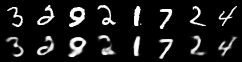

====> Test set loss: 90.0574
====> Test set BCE: 79.9575
Sample of generated images


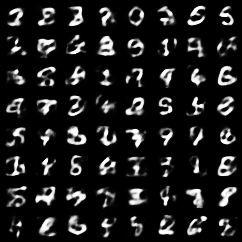



Train Epoch: 6 [0/60000 (0%)]	Loss: 90.542175
Train Epoch: 6 [12800/60000 (21%)]	Loss: 90.138252
Train Epoch: 6 [25600/60000 (43%)]	Loss: 89.943558
Train Epoch: 6 [38400/60000 (64%)]	Loss: 92.444336
Train Epoch: 6 [51200/60000 (85%)]	Loss: 88.502205
====> Epoch: 6 Average train loss: 90.1304
====> Epoch: 6 Average train BCE: 80.1409
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


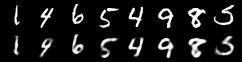

====> Test set loss: 88.9269
====> Test set BCE: 78.9219
Sample of generated images


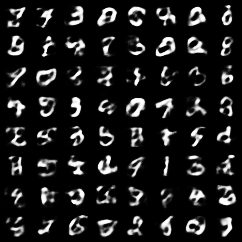



Train Epoch: 7 [0/60000 (0%)]	Loss: 83.800606
Train Epoch: 7 [12800/60000 (21%)]	Loss: 91.162231
Train Epoch: 7 [25600/60000 (43%)]	Loss: 89.645859
Train Epoch: 7 [38400/60000 (64%)]	Loss: 90.552818
Train Epoch: 7 [51200/60000 (85%)]	Loss: 86.804527
====> Epoch: 7 Average train loss: 89.0958
====> Epoch: 7 Average train BCE: 79.0937
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


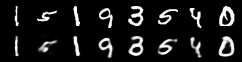

====> Test set loss: 88.1206
====> Test set BCE: 78.0076
Sample of generated images


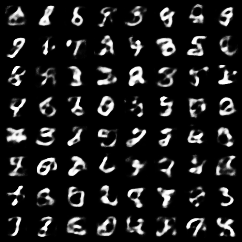



Train Epoch: 8 [0/60000 (0%)]	Loss: 90.822525
Train Epoch: 8 [12800/60000 (21%)]	Loss: 86.769211
Train Epoch: 8 [25600/60000 (43%)]	Loss: 87.931267
Train Epoch: 8 [38400/60000 (64%)]	Loss: 87.441399
Train Epoch: 8 [51200/60000 (85%)]	Loss: 88.912270
====> Epoch: 8 Average train loss: 88.2803
====> Epoch: 8 Average train BCE: 78.2639
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


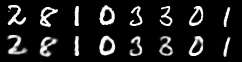

====> Test set loss: 87.3881
====> Test set BCE: 77.3345
Sample of generated images


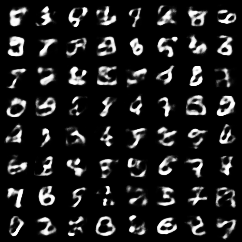



Train Epoch: 9 [0/60000 (0%)]	Loss: 85.618622
Train Epoch: 9 [12800/60000 (21%)]	Loss: 87.970726
Train Epoch: 9 [25600/60000 (43%)]	Loss: 91.240852
Train Epoch: 9 [38400/60000 (64%)]	Loss: 89.897980
Train Epoch: 9 [51200/60000 (85%)]	Loss: 84.478920
====> Epoch: 9 Average train loss: 87.6853
====> Epoch: 9 Average train BCE: 77.6705
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


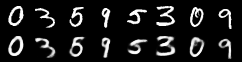

====> Test set loss: 87.0420
====> Test set BCE: 76.8650
Sample of generated images


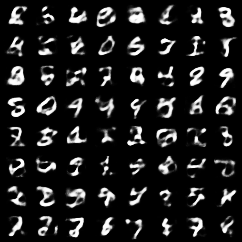



Train Epoch: 10 [0/60000 (0%)]	Loss: 90.161964
Train Epoch: 10 [12800/60000 (21%)]	Loss: 91.053284
Train Epoch: 10 [25600/60000 (43%)]	Loss: 87.917137
Train Epoch: 10 [38400/60000 (64%)]	Loss: 87.853363
Train Epoch: 10 [51200/60000 (85%)]	Loss: 86.741325
====> Epoch: 10 Average train loss: 87.1820
====> Epoch: 10 Average train BCE: 77.1546
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


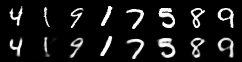

====> Test set loss: 86.5264
====> Test set BCE: 76.3058
Sample of generated images


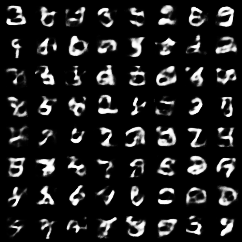

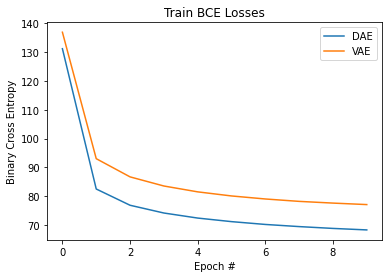

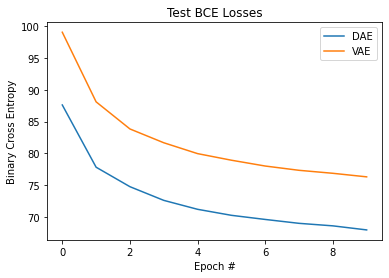

In [ ]:
# train and test DAE
epochs = 10
dae_average_train_BCE = []
dae_average_test_BCE = []
dae_model = DAE().to(device)
dae_optimizer = optim.Adam(dae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_BCE = dae_train(epoch, dae_model, dae_optimizer)
    dae_average_train_BCE.append(average_train_BCE)
    average_test_BCE = dae_test(epoch, dae_model)
    dae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = dae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# train and test VAE
epochs = 10
vae_average_train_losses = []
vae_average_train_BCE = []
vae_average_test_losses = []
vae_average_test_BCE = []
vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_loss, average_train_BCE = vae_train(epoch, vae_model, vae_optimizer)
    vae_average_train_losses.append(average_train_loss)
    vae_average_train_BCE.append(average_train_BCE)
    average_test_loss, average_test_BCE = vae_test(epoch, vae_model)
    vae_average_test_losses.append(average_test_loss)
    vae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = vae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train BCE Losses
plt.plot(dae_average_train_BCE)
plt.plot(vae_average_train_BCE)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

# Plot Test BCE Losses
plt.plot(dae_average_test_BCE)
plt.plot(vae_average_test_BCE)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

###The training BCE Losses and Test BCE Losses cross entropy of VAE is higher than those of DAE. Since VAE need to approximate for the underlying distribution. VAE is probabilistic. VAE will maintain the conditional distribution for the hidden state in the image reconstruction, thus it brings down the quality of reconstruction. This is the cost of maintaining the condition. While DAE is deterministic and it is a exclusively reconstruction of the original image, thus it will have lower BCE losses. The image generated by VAE has a higher quality.